## deepDegron motif analysis


In [1]:
# import needed packages
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
from matplotlib_venn import venn2, venn2_circles
mpl.rcParams['pdf.fonttype'] = 42

### Intersect motifs

In [2]:
# read data
deepDegron_cterm = pd.read_csv('data/motif_enrichment/cterm/dimotif.txt', sep='\t')
deepDegron_nterm = pd.read_csv('data/motif_enrichment/nterm/dimotif.txt', sep='\t')
timms_et_al = pd.read_csv('data/motif_enrichment/Timms_et_al.txt', sep='\t')
koren_et_al = pd.read_csv('data/motif_enrichment/Koren_et_al.txt', sep='\t')

# minor preprocessing
deepDegron_cterm['motif_formatted'] = deepDegron_cterm['motif'].str.replace('^x+', '')
deepDegron_nterm['motif_formatted'] = deepDegron_nterm['motif'].str.replace('x+$', '')

# keep only significant
deepDegron_cterm = deepDegron_cterm[deepDegron_cterm['qvalue']<=0.05]
num_cterm_signif = len(deepDegron_cterm)
deepDegron_nterm = deepDegron_nterm[deepDegron_nterm['qvalue']<=0.05]
num_nterm_signif = len(deepDegron_nterm)

# intersect motifs
cterm_intersect = set(koren_et_al['Motif'].unique()) & set(deepDegron_cterm['motif_formatted'].unique())
nterm_intersect = set(timms_et_al['Motif'].unique()) & set(deepDegron_nterm['motif_formatted'].unique())

# mark overlap
deepDegron_cterm['Koren et al.'] = 0
deepDegron_cterm.loc[deepDegron_cterm['motif_formatted'].isin(cterm_intersect), 'Koren et al.'] = 1
deepDegron_nterm['Timms et al.'] = 0
deepDegron_nterm.loc[deepDegron_nterm['motif_formatted'].isin(nterm_intersect), 'Timms et al.'] = 1

### Overlap of degron motifs

First, we look at the overlap of the motifs between deepDegron and Timms/Koren et al.

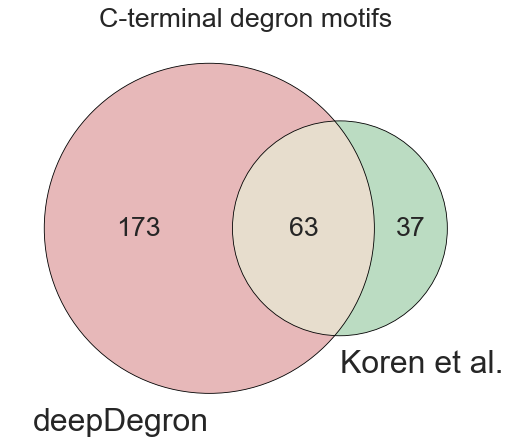

In [4]:
overlap = (num_cterm_signif-len(cterm_intersect), 100-len(cterm_intersect), len(cterm_intersect))
# plot venn diagram
with sns.plotting_context('paper', font_scale=2.5):
    venn2(subsets=overlap, set_labels=('deepDegron', 'Koren et al.'))
    venn2_circles(subsets=overlap, linestyle='solid', linewidth=.75)
    plt.title('C-terminal degron motifs', size=24)
    plt.tight_layout()
    plt.savefig('figures/cterminal_motif_venn.pdf')

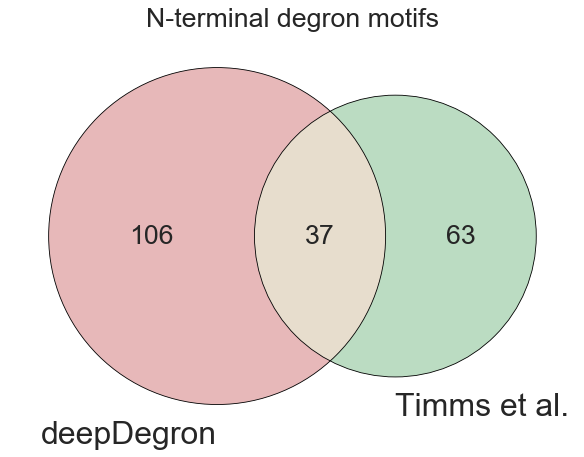

In [5]:
overlap = (num_nterm_signif-len(nterm_intersect), 100-len(nterm_intersect), len(nterm_intersect))
# plot venn diagram
with sns.plotting_context('paper', font_scale=2.5):
    venn2(subsets=overlap, set_labels=('deepDegron', 'Timms et al.'))
    venn2_circles(subsets=overlap, linestyle='solid', linewidth=.75)
    plt.title('N-terminal degron motifs', size=24)
    plt.tight_layout()
    plt.savefig('figures/nterminal_motif_venn.pdf')

### Examine AA usage

Next, we looked at the general amino acid usage.

In [7]:
# count AA usage in motifs
tmp = deepDegron_cterm['motif_formatted'].str.replace('x', '')
dd_cterm_ct1 = tmp.str[0].value_counts()
dd_cterm_ct2 = tmp.str[1].value_counts()
tmp = koren_et_al['Motif'].str.replace('x', '')
koren_cterm_ct1 = tmp.str[0].value_counts()
koren_cterm_ct2 = tmp.str[1].value_counts()
tmp = deepDegron_nterm['motif_formatted'].str.replace('x', '')
dd_nterm_ct1 = tmp.str[0].value_counts()
dd_nterm_ct2 = tmp.str[1].value_counts()
tmp = timms_et_al['Motif'].str.replace('x', '')
timms_nterm_ct1 = tmp.str[0].value_counts()
timms_nterm_ct2 = tmp.str[1].value_counts()

# calc frequency of each AA
frac_dd_cterm_ct1 = dd_cterm_ct1 / dd_cterm_ct1.sum()
frac_dd_cterm_ct2 = dd_cterm_ct2 / dd_cterm_ct2.sum()
frac_dd_nterm_ct1 = dd_nterm_ct1 / dd_nterm_ct1.sum()
frac_dd_nterm_ct2 = dd_nterm_ct2 / dd_nterm_ct2.sum()
frac_koren_cterm_ct1 = koren_cterm_ct1 / koren_cterm_ct1.sum()
frac_koren_cterm_ct2 = koren_cterm_ct2 / koren_cterm_ct2.sum()
frac_timms_nterm_ct1 = timms_nterm_ct1 / timms_nterm_ct1.sum()
frac_timms_nterm_ct2 = timms_nterm_ct2 / timms_nterm_ct2.sum()
aas = sorted(['A', 'R', 'N', 'D', 'C',
       'E', 'Q', 'G', 'H', 'I',
       'L', 'K', 'M', 'F', 'P',
       'S', 'T', 'W', 'Y', 'V'])

# combine into dataframe
cterm = pd.DataFrame({'deepDegron (pos 1)': frac_dd_cterm_ct1,
                      'deepDegron (pos 2)': frac_dd_cterm_ct2,
                      'Koren et al. (pos 1)': frac_koren_cterm_ct1,
                      'Koren et al. (pos 2)': frac_koren_cterm_ct2}).loc[aas].fillna(0).reset_index()
nterm = pd.DataFrame({'deepDegron (pos 1)': frac_dd_nterm_ct1,
                      'deepDegron (pos 2)': frac_dd_nterm_ct2,
                      'Timms et al. (pos 1)': frac_timms_nterm_ct1,
                      'Timms et al. (pos 2)': frac_timms_nterm_ct2}).loc[aas].fillna(0).reset_index()


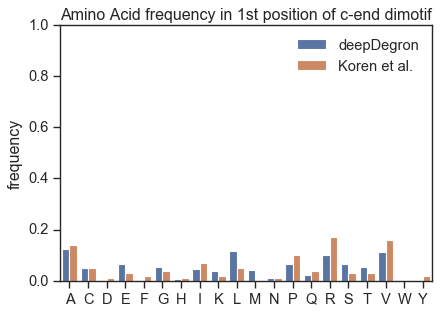

In [8]:
cols_of_interest = ['deepDegron (pos 1)', 'Koren et al. (pos 1)']
plot_df = pd.melt(cterm, id_vars='index', value_vars=cols_of_interest, var_name='analysis')
plot_df['analysis'] = plot_df['analysis'].apply({c: c.split('(')[0].strip() for c in cols_of_interest}.get)
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.2):
    sns.barplot(x='index', y='value', hue='analysis', data=plot_df)
    plt.ylim(0, 1)
    plt.gcf().set_size_inches(6,4)
    plt.ylabel('frequency')
    plt.xlabel('')
    plt.legend(frameon=False)
    plt.title('Amino Acid frequency in 1st position of c-end dimotif')

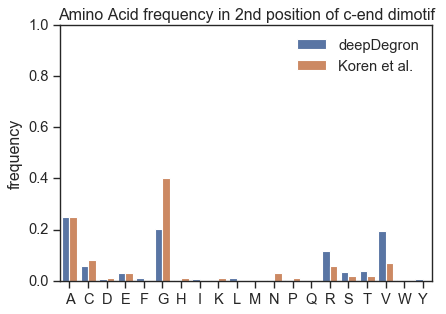

In [9]:
cols_of_interest = ['deepDegron (pos 2)', 'Koren et al. (pos 2)']
plot_df = pd.melt(cterm, id_vars='index', value_vars=cols_of_interest, var_name='analysis')
plot_df['analysis'] = plot_df['analysis'].apply({c: c.split('(')[0].strip() for c in cols_of_interest}.get)
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.2):
    sns.barplot(x='index', y='value', hue='analysis', data=plot_df)
    plt.ylim(0, 1)
    plt.gcf().set_size_inches(6,4)
    plt.ylabel('frequency')
    plt.xlabel('')
    plt.legend(frameon=False)
    plt.title('Amino Acid frequency in 2nd position of c-end dimotif')

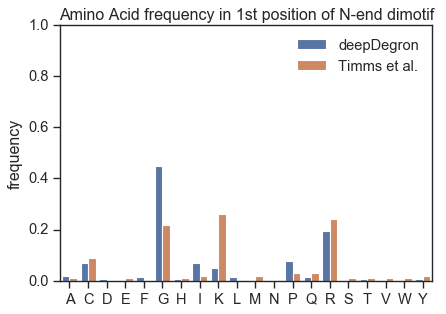

In [10]:
cols_of_interest = ['deepDegron (pos 1)', 'Timms et al. (pos 1)']
plot_df = pd.melt(nterm, id_vars='index', value_vars=cols_of_interest, var_name='analysis')
plot_df['analysis'] = plot_df['analysis'].apply({c: c.split('(')[0].strip() for c in cols_of_interest}.get)
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.2):
    sns.barplot(x='index', y='value', hue='analysis', data=plot_df)
    plt.ylim(0, 1)
    plt.gcf().set_size_inches(6,4)
    plt.ylabel('frequency')
    plt.xlabel('')
    plt.legend(frameon=False)
    plt.title('Amino Acid frequency in 1st position of N-end dimotif')

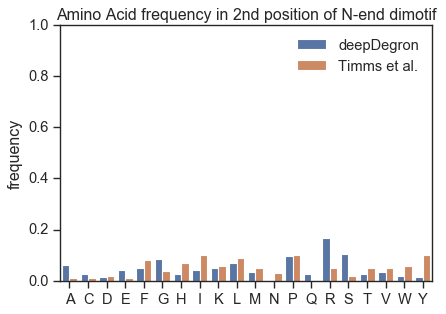

In [11]:
cols_of_interest = ['deepDegron (pos 2)', 'Timms et al. (pos 2)']
plot_df = pd.melt(nterm, id_vars='index', value_vars=cols_of_interest, var_name='analysis')
plot_df['analysis'] = plot_df['analysis'].apply({c: c.split('(')[0].strip() for c in cols_of_interest}.get)
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.2):
    sns.barplot(x='index', y='value', hue='analysis', data=plot_df)
    plt.ylim(0, 1)
    plt.gcf().set_size_inches(6,4)
    plt.ylabel('frequency')
    plt.xlabel('')
    plt.legend(frameon=False)
    plt.title('Amino Acid frequency in 2nd position of N-end dimotif')

### Save motif tables



In [101]:
output_cols = ['motif', 'top sequence motif count', 'all sequence motif count',
               'number of top sequences', 'total number of sequences', 'log(OR)', 'pvalue', 'qvalue', 'Koren et al.']
rename_dict = {'top ct': 'top sequence motif count', 'bot ct': 'all sequence motif count',
               'top total': 'number of top sequences', 'bot total': 'total number of sequences'}
deepDegron_cterm.rename(columns=rename_dict)[output_cols].to_clipboard(sep='\t', index=False)

In [103]:
output_cols = ['motif', 'top sequence motif count', 'all sequence motif count',
               'number of top sequences', 'total number of sequences', 'log(OR)', 'pvalue', 'qvalue', 'Timms et al.']
rename_dict = {'top ct': 'top sequence motif count', 'bot ct': 'all sequence motif count',
               'top total': 'number of top sequences', 'bot total': 'total number of sequences'}
deepDegron_nterm.rename(columns=rename_dict)[output_cols].to_clipboard(sep='\t', index=False)